In [1]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
#!pip install db-dtypes
#!pip install --upgrade google-cloud-bigquery google-cloud-storage google-cloud-bigquery-storage

In [3]:
import google
print(google.__file__)

None


In [4]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='film-wizard-453315')

# BigQuery
from google.cloud import bigquery
from google.cloud import bigquery_storage
print("BigQuery Storage API is installed successfully!")
bigquery_client = bigquery.Client(project='film-wizard-453315')

print("Clients initialized successfully!")

BigQuery Storage API is installed successfully!
Clients initialized successfully!


## Import Scripts

In [5]:
client = bigquery_client

query = 'SELECT * FROM `film-wizard-453315.scripts_preproc.processed_scripts_full`'
script_df = client.query(query).to_dataframe()

In [6]:
import pandas as pd

In [7]:
# project_id = 'film-wizard-453315'  # GCP Project ID
# dataset_id = "scripts_preproc"  # dataset name
# table_id = 'processed_scripts_full'  # Replace with your table name
# client = bigquery_client
# script_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")

In [8]:
script_df = script_df.drop_duplicates(subset=['URL']).reset_index(drop= True)
script_df.dtypes, script_df.isnull().sum()

(lower_title           object
 Title                 object
 URL                   object
 Script                object
 Clean_Script          object
 joy                  float64
 neutral              float64
 sadness              float64
 surprise             float64
 anger                float64
 disgust              float64
 fear                 float64
 sentiment_entropy    float64
 sentiment_std        float64
 hapax                  Int64
 fkgl                 float64
 fre                  float64
 smog                 float64
 fog                  float64
 word count             Int64
 TTR                  float64
 script_length          Int64
 mean_word_length     float64
 dtype: object,
 lower_title             0
 Title                   0
 URL                     0
 Script                  0
 Clean_Script            0
 joy                   927
 neutral               466
 sadness               227
 surprise              262
 anger                1152
 disgust              72

In [9]:
# query = '''
# SELECT title, overview, release_date, runtime, genre_1, genre_2, genre_3

# FROM `film-wizard-453315.tmdb_metadata.movie_details`
# '''

# # Run the query and store the results in a DataFrame
# tmdb_df = client.query(query).to_dataframe()

# #preprocess
# tmdb_df['release_year'] = tmdb_df['release_date'].astype(str).str[:4]
# tmdb_df['lower_title'] = tmdb_df['title'].apply(str.lower) + ' (' + tmdb_df['release_year'] + ')'

# unique_genres = tmdb_df['genre_1'].unique().tolist()

In [10]:
len(unique_genres)

20

## Import TMDB


In [11]:
query = '''
SELECT tmdbId, overview, title, release_date, runtime, genre_1, genre_2, genre_3


FROM `film-wizard-453315.tmdb_metadata.movie_details`
'''

# Run the query and store the results in a DataFrame
tmdb_df = client.query(query).to_dataframe()

#preprocess
tmdb_df['release_year'] = tmdb_df['release_date'].astype(str).str[:4]
tmdb_df['lower_title'] = tmdb_df['title'].apply(str.lower) + ' (' + tmdb_df['release_year'] + ')'
tmdb_df['genres'] = tmdb_df['genre_1'].astype(str) + ' ' + tmdb_df['genre_2'].astype(str) + ' ' + tmdb_df['genre_3'].astype(str)
tmdb_df['genres'] = tmdb_df['genres'].str.replace('None', '').str.strip().apply(str.upper)
tmdb_df.drop(columns = ['genre_1','genre_2','genre_3','release_date'], inplace=True)
tmdb_df = tmdb_df.drop_duplicates(subset=['lower_title']).reset_index(drop= True)
# replace zero runtime with average
mean_runtime = tmdb_df[tmdb_df['runtime'] != 0]['runtime'].mean()
# Replace zeros with the calculated mean
tmdb_df['runtime'] = tmdb_df['runtime'].replace(0, mean_runtime)


tmdb_df.describe()


,tmdbId,runtime
count,86143.0,86137.000000
mean,239837.874453,92.279317
std,246666.044615,52.689389
min,2.0,1.000000
25%,46386.5,84.000000
50%,136966.0,93.000000
75%,379307.0,105.000000
max,1186337.0,12480.000000


In [12]:
#merge dataframes 
df_merged = pd.merge(script_df, tmdb_df, how = 'inner', on = 'lower_title')
#df = df.drop_duplicates(subset=['lower_title'])
df_merged['words_per_minute'] = df_merged['script_length'] / df_merged['runtime']
df_merged.columns

Index(['lower_title', 'Title', 'URL', 'Script', 'Clean_Script', 'joy',
       'neutral', 'sadness', 'surprise', 'anger', 'disgust', 'fear',
       'sentiment_entropy', 'sentiment_std', 'hapax', 'fkgl', 'fre', 'smog',
       'fog', 'word count', 'TTR', 'script_length', 'mean_word_length',
       'tmdbId', 'overview', 'title', 'runtime', 'release_year', 'genres',
       'words_per_minute'],
      dtype='object')

In [18]:
cols = ['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']
df_merged.loc[:, cols] = df_merged[cols].fillna(0)
df_merged.loc[df_merged['fre'] < 0, 'fre'] = 0
df_merged.loc[df_merged['fkgl'] <= 0, 'fkgl'] = 0.0001
df_merged[['sentiment_entropy', 'sentiment_std']] = df_merged[['sentiment_entropy', 'sentiment_std']].fillna(df_merged[['sentiment_entropy', 'sentiment_std']].mean())
df_merged = df_merged.dropna()
df_merged = df_merged.drop_duplicates(subset=['lower_title'])
df_merged.isnull().sum()
#df_merged= df_merged.set_index('tmdbId', drop = True)
df_merged


,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,TTR,script_length,mean_word_length,tmdbId,overview,title,runtime,release_year,genres,words_per_minute
0,police (1916),Police (1916),/movie_script.php?movie=police,Charles Chaplin in Police\n Once again in the ...,"[charles, chaplin, in, police, once, again, in...",0.000000,0.000000,0.000000,0.000000,0.000000,...,0.620690,87,3.770115,53414,Charlie is released from prison and immediatel...,Police,26.0,1916,COMEDY,3.346154
1,dukhtar (2014),Dukhtar (2014),/movie_script.php?movie=dukhtar,"DUKHTAR\n One day, I'll have\n a house like th...","[dukhtar, one, day, ill, have, a, house, like,...",0.026316,0.184211,0.131579,0.157895,0.105263,...,0.212221,3944,3.883621,287594,"In the mountains of Pakistan, a mother and her...",Dukhtar,93.0,2014,DRAMA THRILLER,42.408602
2,moonlight (2002),Moonlight (2002),/movie_script.php?movie=moonlight,I just don't feel anything.\n Since when have ...,"[i, just, dont, feel, anything, since, when, h...",0.000000,0.000000,0.200000,0.500000,0.100000,...,0.360122,983,3.851475,69530,Claire lives with her wealthy adopted parents ...,Moonlight,91.0,2002,THRILLER ROMANCE,10.802198
3,fauve (2018),Fauve (2018),/movie_script.php?movie=fauve,1\n Open up!\n Open up!\n You are such a pussy...,"[open, up, open, up, you, are, such, a, pussy,...",0.000000,0.000000,0.000000,0.333333,0.333333,...,0.398524,542,3.645756,504969,"Set in a surface mine, two boys sink into a se...",Fauve,17.0,2018,DRAMA,31.882353
4,irreversible (2002),Irreversible (2002),/movie_script.php?movie=irreversible,Shall I tell you something?\n Time ruins every...,"[shall, i, tell, you, something, time, ruins, ...",0.068966,0.086207,0.137931,0.120690,0.396552,...,0.153434,6159,3.837149,979,A woman’s lover and her ex-boyfriend take just...,Irreversible,94.0,2002,DRAMA THRILLER CRIME,65.521277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19619,marius (1931),Marius (1931),/movie_script.php?movie=marius,"- Hey, Marius.\n - Yes, Fanny?\n - What are yo...","[hey, marius, yes, fanny, what, are, you, thin...",0.076923,0.142857,0.252747,0.142857,0.131868,...,0.165993,9645,3.903577,42818,"César runs a bar along Marseilles' port, assis...",Marius,127.0,1931,COMEDY DRAMA ROMANCE,75.944882
19620,my brother the devil (2012),My Brother the Devil (2012),/movie_script.php?movie=my-brother-the-devil,Brother!\n What is it? Ah...\n - All fucked up...,"[brother, what, is, it, ah, all, fucked, up, m...",0.042553,0.106383,0.106383,0.234043,0.212766,...,0.169702,4997,3.768261,84316,"Fourteen-year-old Mo is a lonely, sensitive bo...",My Brother the Devil,111.0,2012,DRAMA,45.018018
19621,hellion (2014),Hellion (2014),/movie_script.php?movie=hellion,Jacob! Wait!\n Check this out guys!\n Hey! Com...,"[jacob, wait, check, this, out, guys, hey, com...",0.128205,0.102564,0.230769,0.153846,0.230769,...,0.218902,4116,3.849854,244536,"When motocross and heavy metal obsessed, 13-ye...",Hellion,98.0,2014,THRILLER DRAMA,42.0
19622,cross wars (2017),Cross Wars (2017),/movie_script.php?movie=cross-wars,"Hi, you don't happen to have the...\n The cros...","[hi, you, dont, happen, to, have, the, the, cr...",0.093333,0.360000,0.146667,0.093333,0.040000,...,0.180031,7732,3.928220,412452,Cross is aided by his team of weapons experts ...,Cross Wars,98.0,2017,ACTION,78.897959


In [58]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re  # Import regular expression module

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Stopwords, Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing Function
def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string values
        return ''
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize & Lowercase
    tokens = word_tokenize(text.lower())
    # Remove punctuation & stopwords
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df1 = df_merged
# Apply preprocessing
df1["clean_overview"] = df1["overview"].apply(preprocess_text)

# Vectorize using CountVectorizer (Bag-of-Words Model)
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(df1["clean_overview"])
vocab = count_vectorizer.get_feature_names_out()

# Compute word frequencies
word_counts = X_bow.toarray().sum(axis=0)  # Sum word occurrences across all rows

# Identify words appearing more than 10 times
words_to_keep = [word for word, count in zip(vocab, word_counts) if count > 700]

# Refit CountVectorizer with filtered vocabulary
filtered_vectorizer = CountVectorizer(vocabulary=words_to_keep)
X_bow_filtered = filtered_vectorizer.fit_transform(df1["clean_overview"])

# Convert to DataFrame and join with the original dataframe
vectorized_texts = pd.DataFrame(
    X_bow_filtered.toarray(),
    columns=filtered_vectorizer.get_feature_names_out(),
    index=df1.index
)
vectorized_texts.columns

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Index(['american', 'back', 'become', 'becomes', 'begin', 'boy', 'brother',
       'child', 'city', 'come', 'daughter', 'day', 'death', 'fall', 'family',
       'father', 'film', 'find', 'first', 'friend', 'get', 'girl', 'go',
       'group', 'help', 'high', 'home', 'life', 'love', 'make', 'man', 'meet',
       'mother', 'murder', 'must', 'mysterious', 'new', 'old', 'one', 'people',
       'return', 'save', 'school', 'secret', 'set', 'small', 'son', 'soon',
       'story', 'take', 'team', 'three', 'time', 'together', 'town', 'try',
       'turn', 'two', 'war', 'way', 'wife', 'woman', 'work', 'world', 'year',
       'young'],
      dtype='object')

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer
df2 = df_merged
def preprocess_genres(genres):
    # Tokenize the genres (in this case, it's a simple space-separated string)
    genres = genres.lower()  # Convert to lowercase
    genres = genres.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return ' '.join(word_tokenize(genres))  # Tokenize and rejoin into a string

df2['clean_genres'] = df2['genres'].apply(preprocess_genres)

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Apply the vectorizer to the cleaned genres column
tfidf_matrix = vectorizer.fit_transform(df2['clean_genres'])

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()+'_genre', index = df2.index)

# Display the resulting DataFrame of genre embeddings
df_combined = pd.concat([df2, vectorized_texts, tfidf_df], axis=1)
df_genre_only = pd.concat([df2, tfidf_df], axis=1)


In [890]:
df_genre_only


,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,horror_genre,movie_genre,music_genre,mystery_genre,romance_genre,science_genre,thriller_genre,tv_genre,war_genre,western_genre
0,sombre (1998),Sombre (1998),/movie_script.php?movie=sombre,Thump him!\n Thump him!\n Behind...\n Behind y...,"[thump, him, thump, him, behind, behind, you, ...",0.200000,0.000000,0.266667,0.066667,0.200000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,savior (1998),Savior (1998),/movie_script.php?movie=savior,"Christian, how are you, son?\n Good. You misse...","[christian, how, are, you, son, good, you, mis...",0.000000,0.080000,0.280000,0.080000,0.240000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,"aloha, bobby and rose (1975)","Aloha, Bobby and Rose (1975)",/movie_script.php?movie=aloha-bobby-and-rose,"From the big\n band years of the '40s,\n Artie...","[from, the, big, band, years, of, the, 40s, ar...",0.181818,0.254545,0.036364,0.236364,0.090909,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,money train (1995),Money Train (1995),/movie_script.php?movie=money-train,MONEY TRAIN\n Merry Christmas.\n Watch it!\n T...,"[money, train, merry, christmas, watch, it, th...",0.074074,0.148148,0.092593,0.055556,0.277778,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,blue story (2019),Blue Story (2019),/movie_script.php?movie=blue-story,1\n [RADIO CUTTING IN AND OUT]\n [MALE REPORTE...,"[radio, cutting, in, and, out, male, reporter,...",0.083333,0.159091,0.181818,0.075758,0.371212,...,0.0,0.0,0.838344,0.0,0.545142,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19619,marius (1931),Marius (1931),/movie_script.php?movie=marius,"- Hey, Marius.\n - Yes, Fanny?\n - What are yo...","[hey, marius, yes, fanny, what, are, you, thin...",0.076923,0.142857,0.252747,0.142857,0.131868,...,0.0,0.0,0.000000,0.0,0.697964,0.0,0.000000,0.0,0.0,0.0
19620,my brother the devil (2012),My Brother the Devil (2012),/movie_script.php?movie=my-brother-the-devil,Brother!\n What is it? Ah...\n - All fucked up...,"[brother, what, is, it, ah, all, fucked, up, m...",0.042553,0.106383,0.106383,0.234043,0.212766,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
19621,hellion (2014),Hellion (2014),/movie_script.php?movie=hellion,Jacob! Wait!\n Check this out guys!\n Hey! Com...,"[jacob, wait, check, this, out, guys, hey, com...",0.128205,0.102564,0.230769,0.153846,0.230769,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.814860,0.0,0.0,0.0
19622,cross wars (2017),Cross Wars (2017),/movie_script.php?movie=cross-wars,"Hi, you don't happen to have the...\n The cros...","[hi, you, dont, happen, to, have, the, the, cr...",0.093333,0.360000,0.146667,0.093333,0.040000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

In [67]:
df = df_combined
features = df.drop(columns=df.select_dtypes(include='object').columns)

# Standardize the features for better clustering
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

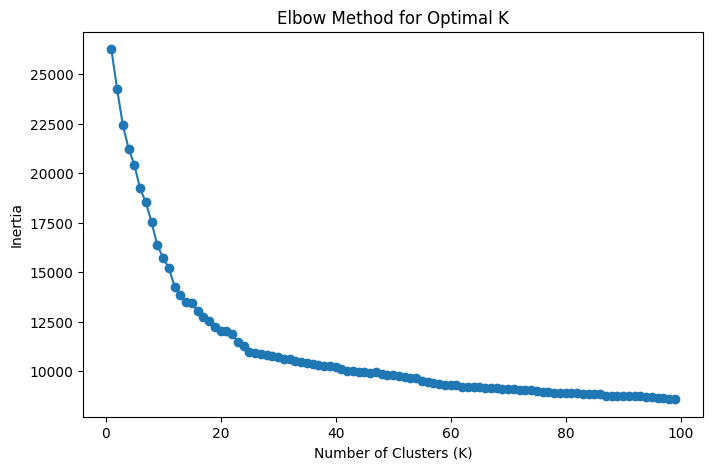

In [47]:
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 100)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [68]:
kmeans = KMeans(n_clusters=200, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_scaled)

# Show sample clustered data
df[['Title', 'sadness', 'joy', 'Cluster', 'genres']].head()

,Title,sadness,joy,Cluster,genres
0,Police (1916),0.000000,0.000000,103,COMEDY
1,Dukhtar (2014),0.131579,0.026316,57,DRAMA THRILLER
2,Moonlight (2002),0.200000,0.000000,116,THRILLER ROMANCE
3,Fauve (2018),0.000000,0.000000,177,DRAMA
4,Irreversible (2002),0.137931,0.068966,23,DRAMA THRILLER CRIME


In [71]:

#film_string = 'Grown Ups (2010)' # Title (Year)
film_string = 'Star Wars (1977)' # Title (Year)
#film_string = 'Django Unchained (2012)' # Title (Year)

overview = df[df['Title']==film_string][['Title','Cluster']]
print(overview)
cluster = int(overview['Cluster'])
df[df['Cluster']==cluster][['Title','neutral','war','sentiment_entropy','words_per_minute', 'genres']]

                  Title  Cluster
10610  Star Wars (1977)      104


/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_22669/1061303166.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(overview['Cluster'])


,Title,neutral,war,sentiment_entropy,words_per_minute,genres
67,Star Trek V: The Final Frontier (1989),0.260870,0,1.337778,65.283019,SCIENCE FICTION ACTION ADVENTURE
248,Mega Piranha (2010),0.173913,0,1.264650,50.152174,ACTION ADVENTURE SCIENCE FICTION
397,Independence Day (1996),0.104000,0,1.284399,85.517241,ACTION ADVENTURE SCIENCE FICTION
409,Wing Commander (1999),0.298701,0,1.213586,72.65,SCIENCE FICTION ACTION ADVENTURE
456,Star Trek VI: The Undiscovered Country (1991),0.227848,1,1.184032,66.893805,SCIENCE FICTION ACTION ADVENTURE
...,...,...,...,...,...,...
17996,Beyond Skyline (2017),0.093023,0,1.322270,41.161905,ACTION SCIENCE FICTION ADVENTURE
18224,Maze Runner: The Death Cure (2018),0.166667,0,1.442482,48.573427,SCIENCE FICTION ACTION ADVENTURE
19121,Jumper (2008),0.319149,1,1.209063,57.113636,ACTION ADVENTURE SCIENCE FICTION
19370,Zone Troopers (1985),0.285714,0,0.857436,49.953488,ACTION ADVENTURE SCIENCE FICTION


In [73]:
film_string = 'Django Unchained (2012)' # Title (Year)

overview = df_combined[df_combined['Title']==film_string][['Title','Cluster']]
print(overview)
cluster = int(overview['Cluster'])
df_combined[df_combined['Cluster']==cluster][['Title','words_per_minute', 'anger']]

                       Title  Cluster
288  Django Unchained (2012)        8


/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_22669/2836879271.py:5: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(overview['Cluster'])


,Title,words_per_minute,anger
288,Django Unchained (2012),78.048485,0.327869
1647,Man with the Gun (1955),100.590361,0.115385
1770,The Hired Hand (1971),41.351648,0.142857
3746,The Great Scout & Cathouse Thursday (1976),82.607843,0.139241
4413,Something Big (1971),78.083333,0.063291
5085,Decision at Sundown (1957),93.858974,0.086957
5634,Paint Your Wagon (1969),78.804878,0.122951
8179,Ambush at Dark Canyon (2012),66.2,0.250000
8667,Silver River (1948),99.909091,0.095238
8819,Bone Tomahawk (2015),53.503759,0.058824


In [44]:
from sklearn.cluster import DBSCAN

df = df_combined
features = df.drop(columns=['tmdbId', 'runtime']).drop(columns=df.select_dtypes(include='object'))

#Standardize the features
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=1, min_samples=5)  # Adjust eps and min_samples as needed
df['Cluster'] = dbscan.fit_predict(features_scaled)
#features_scaled_df.describe().apply(lambda x: round(x,2))
print('Unclustered Films: ',len(df[df.Cluster == -1]))


Unclustered Films:  213


In [45]:
df['Cluster'].value_counts().median()


486.5

In [38]:
film_string = 'Grown Ups (2010)' # Title (Year)
#film_string = 'Star Wars (1977)' # Title (Year)
#film_string = 'Django Unchained (2012)' # Title (Year)

overview = df[df['Title']==film_string][['Title','Cluster']]
print(overview)
cluster = int(overview['Cluster'])
df[df['Cluster']==cluster][['Title','sentiment_entropy','words_per_minute', 'genres']]

                  Title  Cluster
16339  Grown Ups (2010)        0


/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_22669/640196962.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(overview['Cluster'])


,Title,sentiment_entropy,words_per_minute,genres
0,Police (1916),1.322270,3.346154,COMEDY
1,Dukhtar (2014),1.415737,42.408602,DRAMA THRILLER
3,Fauve (2018),1.322270,31.882353,DRAMA
4,Irreversible (2002),0.507383,65.521277,DRAMA THRILLER CRIME
5,The Evictors (1979),1.483012,54.51087,CRIME HORROR THRILLER
...,...,...,...,...
19619,Marius (1931),1.263537,75.944882,COMEDY DRAMA ROMANCE
19620,My Brother the Devil (2012),0.900338,45.018018,DRAMA
19621,Hellion (2014),1.295500,42.0,THRILLER DRAMA
19622,Cross Wars (2017),1.394732,78.897959,ACTION


In [39]:
df[df['Cluster']==17][['Title','joy', 'neutral', 'sentiment_entropy','words_per_minute', 'genres']]

,Title,joy,neutral,sentiment_entropy,words_per_minute,genres


In [917]:
df = df.drop(columns=['title'])

In [918]:
#Clusters in Pure Classes
df[df.comedy_genre == 1][['Title','genres','Cluster']].value_counts() #comedy all in one cluster
df[df.comedy_genre == 1]['Cluster'].value_counts() #comedy all in one cluster
#df[df.drama_genre == 1]['Cluster'].value_counts() #drama in 2 clusters
#df[df.action_genre == 1]['Cluster'].value_counts() #action in one cluster
#df[df.horror_genre == 1]['Cluster'].value_counts() #horror in one cluster
# df[df.animation_genre == 1]['Cluster'].value_counts() #animation in one cluster

Cluster
 14    1005
-1        6
Name: count, dtype: int64

## Log Scaling the Script



In [936]:

from sklearn.cluster import DBSCAN

df = df_genre_only
#df.set_index('tmdbId', drop = True, inplace = True)

features = df.drop(columns=['tmdbId', 'runtime']).drop(columns=df.select_dtypes(include='object'))
script_columns = ['joy', 'neutral', 'sadness', 'surprise', 'anger', 'disgust', 'fear',
       'sentiment_entropy', 'sentiment_std', 'hapax', 'fkgl', 'fre', 'smog',
       'fog', 'word count', 'TTR', 'script_length', 'mean_word_length',
       'words_per_minute']
features[script_columns] =  np.sqrt(features[script_columns])

# # Standardize the genre features
scaler = MinMaxScaler()

features_scaled = scaler.fit_transform(features)
features_scaled_df = pd.DataFrame(features_scaled)
features_scaled_df.columns = features.columns

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)  # Adjust eps and min_samples as needed
df['Cluster'] = dbscan.fit_predict(features_scaled_df)
pd.DataFrame(features_scaled_df).describe().apply(lambda x: round(x,2))
print('Unclustered Films: ',len(df[df.Cluster == -1]))

# features[features.isna().any(axis=1)][['joy', 'neutral', 'sadness', 'surprise', 'anger', 'disgust', 'fear',
#        'sentiment_entropy', 'sentiment_std', 'hapax', 'fkgl', 'fre', 'smog',
#        'fog', 'word count', 'TTR', 'script_length', 'mean_word_length',
#        'words_per_minute']
# ]

Unclustered Films:  5910


In [941]:
#film_string = 'Grown Ups (2010)' # Title (Year)
film_string = 'Star Wars (1977)' # Title (Year)
#film_string = 'Django Unchained (2012)' # Title (Year)
#film_string = 'Wedding Crashers (2005)' # Title (Year)
overview = df[df['Title']==film_string][['Title','Cluster']]
print(overview)
cluster = int(overview['Cluster'])
my_cluster = df[df['Cluster']==cluster][['Title','sentiment_entropy','words_per_minute', 'genres']]
my_cluster.genres.value_counts()

                  Title  Cluster
10309  Star Wars (1977)       29


/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_6473/2385971298.py:7: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cluster = int(overview['Cluster'])


genres
DRAMA                              12
COMEDY                              8
HORROR                              4
COMEDY DRAMA                        3
DRAMA ROMANCE                       3
                                   ..
SCIENCE FICTION THRILLER HORROR     1
ANIMATION COMEDY FAMILY             1
MYSTERY THRILLER DRAMA              1
HORROR THRILLER DRAMA               1
THRILLER DRAMA MYSTERY              1
Name: count, Length: 94, dtype: int64

In [866]:
# # BigQuery
# from google.cloud import bigquery, bigquery_storage
# bigquery_client = bigquery.Client(project='film-wizard-453315')

# proccessed_df = df

# project_id = 'film-wizard-453315'  # GCP Project ID
# dataset_id = "clustered_movies"  # dataset name

# table_id = "dbscan_all"  # Replace with your table name

# client = bigquery_client
# proccessed_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")

## No Genres



In [786]:
#merge dataframes 
df_script = pd.merge(script_df, tmdb_df, how = 'inner', on = 'lower_title')
df_script[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']] = df_script[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']].fillna(0)
df_script[['sentiment_entropy', 'sentiment_std']] = df_script[['sentiment_entropy', 'sentiment_std']].fillna(df_script[['sentiment_entropy', 'sentiment_std']].mean())
df_script = df_script.dropna()
df_script = df_script.drop_duplicates(subset=['lower_title'])
df_script['words_per_minute'] = df['script_length'] / df['runtime']
df_script.set_index('tmdbId', drop = True, inplace = True)
df_script2 = df_script.drop(columns=['word count','runtime','release_year','genres', 'title'])
df_script2

features2 = df_script2.drop(columns=df_script2.select_dtypes(include='object').columns)

# Standardize the features
scaler = MinMaxScaler()
features2_scaled = scaler.fit_transform(features2)
features2_scaled_df = pd.DataFrame(features2_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=5)  # Adjust eps and min_samples as needed
df_script['Cluster'] = dbscan.fit_predict(features2_scaled)
#features_scaled_df.describe().apply(lambda x: round(x,2))
print('Unclustered Films: ',len(df_script[df_script.Cluster == -1]))



Unclustered Films:  12425


In [481]:
df_script

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,word count,TTR,script_length,mean_word_length,title,runtime,release_year,genres,words_per_minute,Cluster
tmdbId,,,,,,,,,,,,,,,,,,,,,
72091,voyage to the prehistoric planet (1965),Voyage to the Prehistoric Planet (1965),/movie_script.php?movie=voyage-to-the-prehisto...,"The year, 2020. The moon has been\n explored a...","[the, year, the, moon, has, been, explored, an...",0.080000,0.220000,0.080000,0.220000,0.020000,...,1128,0.226188,4987,4.207740,Voyage to the Prehistoric Planet,78.0,1965,SCIENCE FICTION ADVENTURE,63.935897,-1
569499,detainment (2018),Detainment (2018),/movie_script.php?movie=detainment,1\n Jon.\n Do you know why we\n wanna talk to ...,"[jon, do, you, know, why, we, wanna, talk, to,...",0.000000,0.250000,0.035714,0.071429,0.000000,...,488,0.160158,3047,3.692484,Detainment,30.0,2018,DRAMA CRIME DOCUMENTARY,101.566667,-1
833339,speak no evil (2022),Speak No Evil (2022),/movie_script.php?movie=speak-no-evil-2022,[car traveling]\n - [suspension squeaking]\n -...,"[car, traveling, suspension, squeaking, wind, ...",0.306122,0.183673,0.163265,0.142857,0.020408,...,954,0.211483,4511,4.444912,Speak No Evil,97.0,2022,HORROR THRILLER DRAMA,46.505155,0
44751,dossier k. (2009),Dossier K. (2009),/movie_script.php?movie=dossier-k,BLood is never unavenged\n (Art. 917 of the Ka...,"[blood, is, never, unavenged, art, of, the, ka...",0.015625,0.218750,0.078125,0.109375,0.203125,...,1358,0.212420,6393,4.168466,Dossier K.,120.0,2009,ACTION CRIME DRAMA,53.275,-1
42202,cyclone (1978),Cyclone (1978),/movie_script.php?movie=cyclone,(suspenseful synthwave music)\n - Now ladies a...,"[suspenseful, synthwave, music, now, ladies, a...",0.137255,0.078431,0.156863,0.039216,0.019608,...,1006,0.207166,4856,4.285420,Cyclone,118.0,1978,HORROR,41.152542,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11169,spartan (2004),Spartan (2004),/movie_script.php?movie=spartan,You had your whole life\n to prepare for this ...,"[you, had, your, whole, life, to, prepare, for...",0.037500,0.250000,0.025000,0.137500,0.112500,...,1482,0.177040,8371,3.856290,Spartan,102.0,2004,MYSTERY ACTION DRAMA,82.068627,0
48918,shadow of the wolf (1992),Shadow of the Wolf (1992),/movie_script.php?movie=shadow-of-the-wolf,AGAGUK\n (aka Shadow of the Wolf)\n GRAND NORD...,"[agaguk, aka, shadow, of, the, wolf, grand, no...",0.033333,0.033333,0.166667,0.066667,0.400000,...,622,0.190681,3262,3.693440,Shadow of the Wolf,112.0,1992,ADVENTURE,29.125,-1
13184,bangkok dangerous (2008),Bangkok Dangerous (2008),/movie_script.php?movie=bangkok-dangerous,My job takes me to a lot of places.\n It's got...,"[my, job, takes, me, to, a, lot, of, places, i...",0.100000,0.150000,0.150000,0.100000,0.200000,...,596,0.296076,2013,3.884252,Bangkok Dangerous,99.0,2008,ACTION CRIME THRILLER,20.333333,-1


In [569]:
df_script[df_script['Cluster']==1][['Title','sentiment_entropy','words_per_minute', 'genres']]
def script_classifier(sent_ent):
    if sent_ent > 1.4:
        return 2
    elif sent_ent > 1:
        return 1
    else:
        return 0 
df_script['sent_ent_class'] = df_script['sentiment_entropy'].apply(script_classifier)
df_script['sent_ent_class'].value_counts()


sent_ent_class
1    9557
2    8416
0    1651
Name: count, dtype: int64

In [76]:
df['Cluster'].value_counts()

Cluster
6      511
37     418
111    261
32     256
110    255
      ... 
124     16
126     10
39       8
170      2
150      1
Name: count, Length: 200, dtype: int64

In [77]:
df[['tmdbId','Cluster']]

,tmdbId,Cluster
0,53414,103
1,287594,57
2,69530,116
3,504969,177
4,979,23
...,...,...
19619,42818,105
19620,84316,177
19621,244536,57
19622,412452,40


In [78]:
proccessed_df = df[['tmdbId','Cluster']]

project_id = 'film-wizard-453315'  # GCP Project ID
dataset_id = "clustered_movies"  # dataset name

table_id = "kmeans_v3_slim"  # Replace with your table name

client = bigquery_client
proccessed_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")

/var/folders/xt/0g_4gstj4v7gqfpdt0wv97280000gn/T/ipykernel_22669/3284222694.py:9: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  proccessed_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")
100%|███████████████████████████████████████████████████████| 1/1 [00:00<00:00, 9446.63it/s]
